# Mid Semester Project - Reinforcement Learning 2025

## Tabular RL in MiniGrid Environments

---

### Name and ID:
Student 1: Avital Fine - 208253823

Student 2: Daniel Katz - 315114991

---

<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

---



# 1. Setup and Installation


## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install gymnasium
!pip install minigrid
!pip install pygame


## Imports

In [ ]:
# Imports
from __future__ import annotations

# Standard Library Imports
import base64
import copy
import random
from collections import defaultdict
import time

# Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# Configure Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Environment

## Env

In [ ]:
# =============================================================================
# CONSTANTS & MAPPINGS
# =============================================================================
OBJECT_TO_IDX = {
    "unseen": 0, "empty": 1, "wall": 2, "floor": 3, "door": 4,
    "key": 5, "ball": 6, "box": 7, "goal": 8, "lava": 9, "agent": 10,
}
IDX_TO_OBJECT = {i: name for name, i in OBJECT_TO_IDX.items()}
COLOR_TO_IDX = {name: i for i, name in enumerate(COLOR_NAMES)}
IDX_TO_COLOR = {i: name for i, name in enumerate(COLOR_NAMES)}


In [ ]:
# =============================================================================
# BASE ENVIRONMENT WRAPPER
# =============================================================================
class MiniGridEnv(BaseMiniGridEnv):
    """
    A compatibility wrapper around the modern gymnasium-minigrid BaseMiniGridEnv.
    """
    def __init__(
        self,
        grid_size=None,
        width=None,
        height=None,
        max_steps=10000,
        see_through_walls=False,
        agent_view_size=7,
        render_mode=None,
        mission_space=None,
        **kwargs
    ):
        # Newer Minigrid versions strictly require a MissionSpace.
        # We provide a dummy default if one isn't passed.
        if mission_space is None:
            mission_space = MissionSpace(mission_func=lambda: "do something")

        super().__init__(
            grid_size=grid_size,
            width=width,
            height=height,
            max_steps=max_steps,
            see_through_walls=see_through_walls,
            agent_view_size=agent_view_size,
            render_mode=render_mode,
            mission_space=mission_space,
            **kwargs
        )

    def reset(self, *, seed=None, options=None):
        return super().reset(seed=seed, options=options)


In [ ]:
# =============================================================================
# ENVIRONMENT 1: RANDOM EMPTY GRID
# =============================================================================
class RandomEmptyEnv_10(MiniGridEnv):
    """
    A 10x10 grid environment with no obstacles inside, just outer walls.
    The agent and goal start positions are randomized.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        **kwargs,
    ):
        self.init_agent_pos = agent_start_pos
        self.init_agent_dir = agent_start_dir

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)

        # Heuristic for max steps: typically enough to explore the grid fully
        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True, # Agent has full observability of the room
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)
        # Initialize internal walls list
        self.walls_init = []
        # Default goal position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2) # bottom right corner

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])

        # 2. Call parent reset, which internally calls _gen_grid()
        return super().reset(seed=seed, options=options)

    def _gen_grid(self, width, height):
        """
        Procedurally generates the grid layout: walls, goal, and agent.
        """
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        # Sparse Reward: Only reward 1.0 upon reaching the goal (termination)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0

        return obs, reward, terminated, truncated, info

    # Getters for wrapper compatibility
    def get_k_pos(self): return getattr(self, 'key_pos', None)
    def get_d_pos(self): return getattr(self, 'door_pos', None)
    def get_goal_pos(self): return self.goal_pos


In [ ]:
# =============================================================================
# ENVIRONMENT 2: RANDOM KEY & DOOR
# =============================================================================
class RandomKeyMEnv_10(MiniGridEnv):
    """
    A 10x10 grid separated into two rooms by a vertical wall.
    The agent must find a key, open a locked door, and reach the goal.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        partition_col=3, # Column index where the dividing wall is placed
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.partition_col = partition_col
        self.walls_init = []

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        """
        Generates: Outer walls -> Partition Wall -> Door -> Key -> Goal.
        """
        # 1. Create empty grid and outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # 2. Define Partition Wall and Door Location
        # Choose a random row for the door (pass_loc)
        self.pass_loc = random.choice([op_row for op_row in range(1, height-1)])
        # Create a vertical wall at partition_col
        self.walls_init = [(self.partition_col, i) for i in range(0, height)]

        # Place the partition wall objects
        for column, row in self.walls_init:
            if 0 <= column < width and 0 <= row < height:
                self.grid.set(column, row, Wall())

        # 3. Place Key and Door
        # Key is placed randomly in the left room (columns 1 to partition_col)
        self.key_pos = (
            random.choice([k_col for k_col in range(1, self.partition_col)]),
            random.choice([k_row for k_row in range(2, height-1)])
        )
        self.door_pos = (self.partition_col, self.pass_loc)

        # Place the Locked Door (replaces the wall at pass_loc)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Place the Key
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # 4. Place Goal (Randomly in the right upper or lower corner)
        self.goal_pos = random.choice([(8,1), (8,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 5. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

    def reset(self, *, seed=None, options=None):
        self._gave_key_bonus = False
        self._gave_door_bonus = False
        return super().reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        if terminated:
            reward = 1.0
        else:
            reward = 0.0

        # Reward 1: Picking up the key (given only once)
        currently_carrying = self.carrying is not None and self.carrying.type == 'key'
        if currently_carrying and not self._gave_key_bonus:
            reward += 0.5
            self._gave_key_bonus = True
        # Reward 2: Opening the door (given only once)
        door_currently_open = self.env_door.is_open if hasattr(self, 'env_door') else False
        if door_currently_open and not self._gave_door_bonus:
            reward += 0.5
            self._gave_door_bonus = True

        # punish on each step
        reward -= 0.01

        return obs, reward, terminated, truncated, info

    # Getters
    def get_k_pos(self): return self.key_pos
    def get_d_pos(self): return self.door_pos
    def get_goal_pos(self): return self.goal_pos


## Wrappers

In [ ]:
# =============================================================================
# OBSERVATION WRAPPER
# =============================================================================
class KeyFlatObsWrapper(gym.ObservationWrapper):
    """
    Transforms the observation from a 2D image/grid to a 1D flat vector.
    """
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),
            dtype='uint8'
        )
        self.get_init_map()

    def observation(self, obs):
        """
        Process the grid state into a flat vector.
        """
        env = self.unwrapped

        # 1. Get the full numerical encoding of the grid
        full_grid = env.grid.encode()

        # 2. Inject Agent State
        # Minigrid's 'encode()' often treats the agent separately.
        # Here, we overwrite the grid cell at agent_pos with agent details.
        if env.agent_pos is not None:
            full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
                OBJECT_TO_IDX['agent'],
                COLOR_TO_IDX['red'],
                env.agent_dir
            ])

        # 3. Crop Outer Walls
        # Slicing [1:-1, 1:-1] removes the standard boundary walls to reduce dim.
        full_grid = full_grid[1:-1, 1:-1]

        # 4. Flatten to 1D array
        return full_grid.ravel()

    # --- Helper methods for Analysis / Debugging ---

    def is_carrying_key(self):
        """Check if the agent is currently holding the key object."""
        return self.unwrapped.carrying is not None and self.unwrapped.carrying.type == 'key'

    def is_door_open(self):
        """Check the state of the specific environment door."""
        if hasattr(self.unwrapped, 'env_door') and self.unwrapped.env_door:
            return self.unwrapped.env_door.is_open
        return False

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
        """
        Creates a binary map (walls vs empty) of the environment structure.
        Used for visualization or pathfinding heuristics.
        """
        env = self.unwrapped
        # Note: Minigrid uses (x, y), numpy uses (row, col) -> (y, x).
        map_u = np.zeros((env.height, env.width), dtype=int)

        # Mark outer walls
        map_u[0, :] = 1
        map_u[-1, :] = 1
        map_u[:, 0] = 1
        map_u[:, -1] = 1

        # Mark inner walls
        if hasattr(env, 'walls_init'):
            for x, y in env.walls_init:
                if 0 <= y < env.height and 0 <= x < env.width:
                    map_u[y, x] = 1

        self.init_map = map_u.tolist()

    def get_updated_map(self):
        """
        Returns a character-based map (ASCII) showing the current state
        of entities (Agent 'P', Goal 'G', Door 'D', Key 'K').
        """
        current_map = copy.deepcopy(self.init_map)

        # 1. Place Agent ('P' for Player)
        ax, ay = self.unwrapped.agent_pos
        current_map[ay][ax] = 'P'

        # 2. Place Goal ('G')
        gx, gy = self.unwrapped.goal_pos
        current_map[gy][gx] = 'G'

        # 3. Place Door ('D') if closed
        if hasattr(self.unwrapped, 'door_pos') and not self.is_door_open():
            dx, dy = self.unwrapped.door_pos
            current_map[dy][dx] = 'D'

        # 4. Place Key ('K') if not carried
        if hasattr(self.unwrapped, 'key_pos') and not self.is_carrying_key():
            kx, ky = self.unwrapped.key_pos
            current_map[ky][kx] = 'K'

        return current_map


## RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

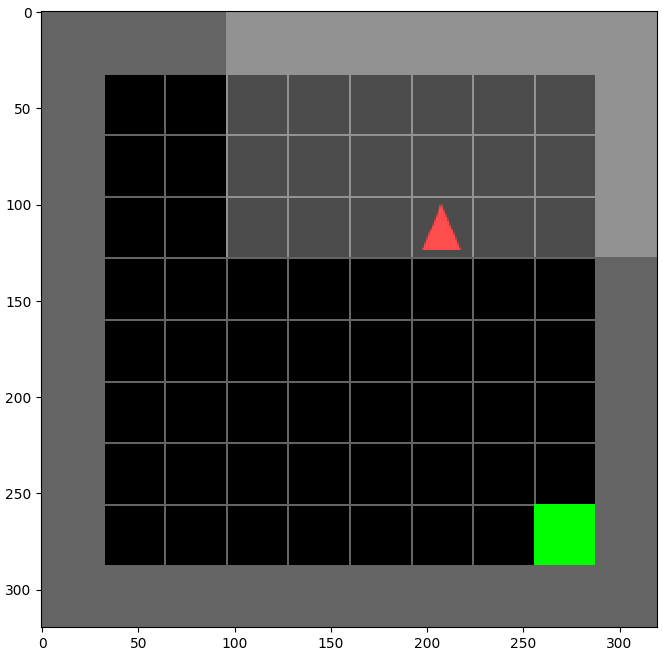

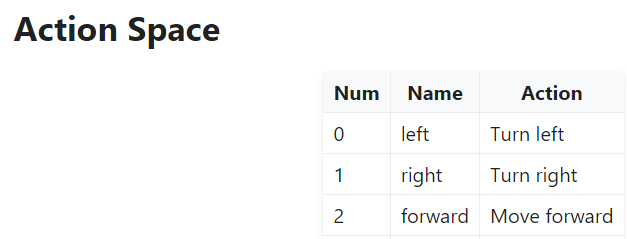

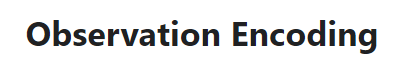

Agent Direction,
Agent Position,
Goal Position

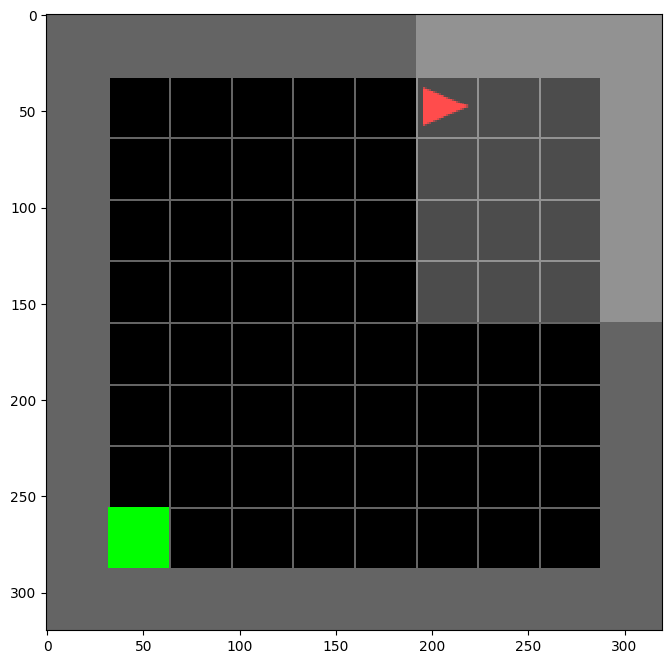

In [ ]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=100))
obs = env.reset()
screen = env.render()
plt.imshow(screen)

In [ ]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


In [ ]:
# obs = env.reset()
# # ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
# print('Carrying Key:', env.is_carrying_key())
# print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (6, 1)
Goal position:  (1, 8)


In [ ]:
#Random action plus visualization
max_steps = 100
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=max_steps))
obs = env.reset()
video_filename = '/content/fn.mp4'

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated #
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 99


## RandomKeyMEnv_10

### Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

- Wall is always in the third column.

- Key is always in the left part (left to the door).

- Goal is randomly in the right upper or lower corner.

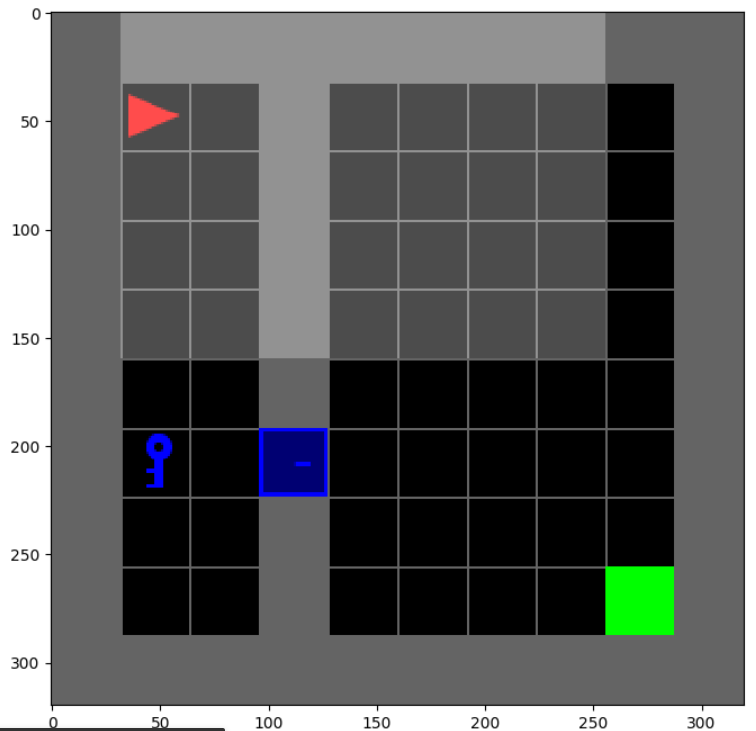

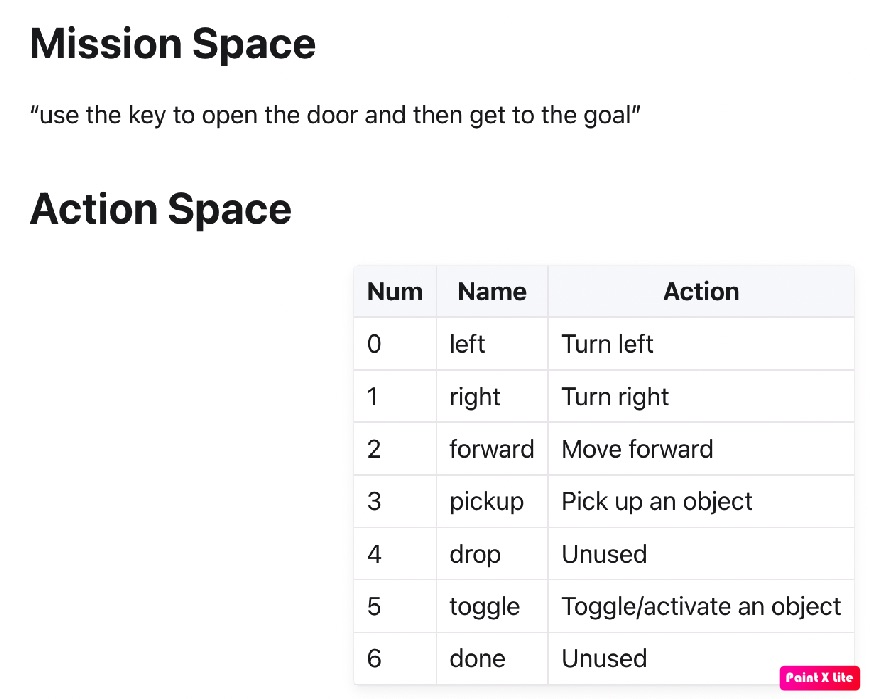

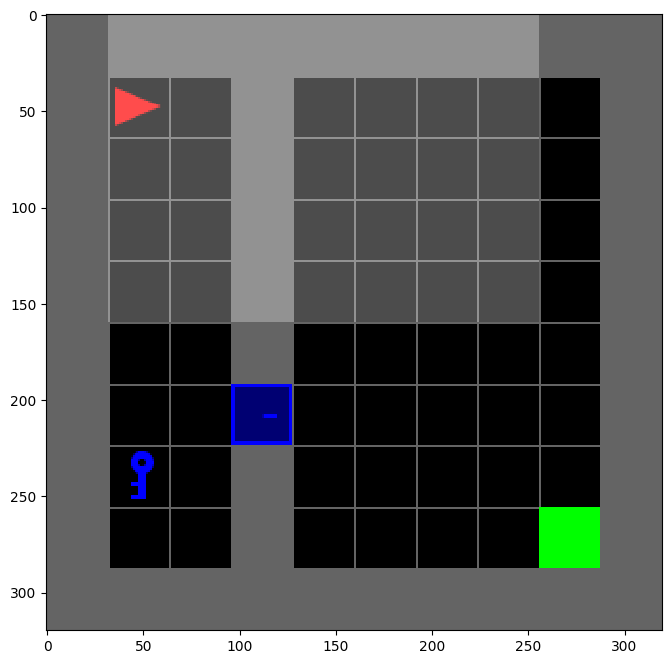

In [ ]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array', max_steps=100))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [ ]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


In [ ]:
# env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
print('Carrying Key:', env.is_carrying_key())
print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (1, 1)
Goal position:  (8, 8)
Carrying Key: False
Door Open: False


# 2. Our Code

## Helpers

In [ ]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def hash_state(state):
    """
    Function to convert state into a hashable type
    """
    if isinstance(state, np.ndarray):
        state = tuple(state)
    else:
        print('Warning: state is not a numpy array')
    return state


def epsilon_greedy_action(Q, state, n_actions, epsilon, avoid_actions = []):
    """
    Select action using epsilon-greedy policy.
    """
    legal_actions = [a for a in range(n_actions) if a not in avoid_actions]

    # Explore
    if random.random() < epsilon:
        return random.choice(legal_actions)

    # Exploit: pick best legal action (random tie-break)
    legal_q = [(a, Q[(state, a)]) for a in legal_actions]
    max_q = max(q for _, q in legal_q)
    best_actions = [a for a, q in legal_q if q == max_q]
    return random.choice(best_actions)

def greedy_action(Q, state, n_actions, avoid_actions=[]):
    """
    Select best action (greedy policy).
    """
    # Use Q[(state, a)] to respect defaultdict's init_q_value
    legal_actions = [a for a in range(n_actions) if a not in avoid_actions]
    legal_q = [(a, Q[(state, a)]) for a in legal_actions]
    max_q = max(q for _, q in legal_q)
    best_actions = [a for a, q in legal_q if q == max_q]
    return random.choice(best_actions)

def running_average(data, window=100):
    """
    Compute running average for plotting.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / window

def decay_epsilon(epsilon, epsilon_min, epsilon_decay):
    """
    Decay epsilon to a minimum value.
    """
    return max(epsilon_min, epsilon * epsilon_decay)

def print_with_seperator(text):
    print("=" * 70)
    print(text)
    print("=" * 70)


## Evaluation and Visualization Functions


In [ ]:
# =============================================================================
# EVALUATION AND VISUALIZATION
# =============================================================================

def evaluate_policy(env, Q, n_episodes=100, max_steps=200, avoid_actions=[]):
    """
    Evaluate the learned policy (greedy, no exploration).
    """
    n_actions = env.action_space.n
    total_rewards = []
    total_steps = []
    successes = 0

    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            hashed_state = hash_state(state)
            action = greedy_action(Q, hashed_state, n_actions, avoid_actions)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1

            if terminated and reward > 0:
                successes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    return {
        'avg_reward': np.mean(total_rewards),
        'avg_steps': np.mean(total_steps),
        'success_rate': successes / n_episodes
    }


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _moving_average(y, window: int):
    y = np.asarray(y, dtype=float)
    if window <= 1 or len(y) < window:
        return np.arange(len(y)), y
    kernel = np.ones(window) / window
    smoothed = np.convolve(y, kernel, mode="valid")
    x = np.arange(window - 1, len(y))
    return x, smoothed

def _ema(y, alpha: float):
    y = np.asarray(y, dtype=float)
    if len(y) == 0:
        return np.array([]), np.array([])
    alpha = float(alpha)
    alpha = min(max(alpha, 0.0), 1.0)
    out = np.empty_like(y, dtype=float)
    out[0] = y[0]
    for i in range(1, len(y)):
        out[i] = alpha * y[i] + (1 - alpha) * out[i - 1]
    return np.arange(len(y)), out

def plot_training_results(results_dict,
                          title="Training Comparison",
                          smooth="ema",
                          ma_window=100,
                          ema_alpha=0.08,
                          show_raw=False,
                          raw_stride=10,
                          raw_alpha=0.12,
                          linewidth=2.5):
    """
    Plots ONLY:
      (1) Episode Rewards (smoothed)
      (2) Episode Lengths / Steps (smoothed)

    results_dict format:
      {
        "MC": {"rewards": [...], "lengths": [...]},
        "SARSA": {"rewards": [...], "lengths": [...]},
        ...
      }
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5.2), dpi=120)
    ax_r, ax_l = axes

    # Use Matplotlib default color cycle (less "hard-coded" and usually looks nice)
    names = list(results_dict.keys())

    def smooth_xy(series):
        if smooth.lower() == "ma":
            return _moving_average(series, ma_window)
        elif smooth.lower() == "ema":
            return _ema(series, ema_alpha)
        else:
            # no smoothing
            y = np.asarray(series, dtype=float)
            return np.arange(len(y)), y

    # --- Rewards ---
    for name in names:
        rewards = results_dict[name].get("rewards", [])
        if len(rewards) == 0:
            continue

        x_s, y_s = smooth_xy(rewards)
        line = ax_r.plot(x_s, y_s, label=name, linewidth=linewidth)[0]

        if show_raw:
            xs = np.arange(0, len(rewards), max(1, int(raw_stride)))
            ax_r.plot(xs, np.asarray(rewards)[xs],
                      linestyle="none", marker=".", markersize=2.5,
                      alpha=raw_alpha, color=line.get_color())

    ax_r.set_title("Episode Rewards")
    ax_r.set_xlabel("Episode")
    ax_r.set_ylabel("Reward")
    ax_r.grid(True, alpha=0.25)
    ax_r.margins(x=0)

    # --- Lengths ---
    for name in names:
        lengths = results_dict[name].get("lengths", [])
        if len(lengths) == 0:
            continue

        x_s, y_s = smooth_xy(lengths)
        line = ax_l.plot(x_s, y_s, label=name, linewidth=linewidth)[0]

        if show_raw:
            xs = np.arange(0, len(lengths), max(1, int(raw_stride)))
            ax_l.plot(xs, np.asarray(lengths)[xs],
                      linestyle="none", marker=".", markersize=2.5,
                      alpha=raw_alpha, color=line.get_color())

    ax_l.set_title("Episode Lengths (Steps to Finish)")
    ax_l.set_xlabel("Episode")
    ax_l.set_ylabel("Steps")
    ax_l.grid(True, alpha=0.25)
    ax_l.margins(x=0)

    # One shared legend (cleaner)
    handles, labels = ax_r.get_legend_handles_labels()

    # Put title and legend in dedicated top space (no overlap)
    fig.suptitle(title, fontsize=14, fontweight="bold", y=0.985)
    fig.legend(handles, labels,
               loc="upper center",
               bbox_to_anchor=(0.5, 0.945),
               ncol=min(4, len(labels)),
               frameon=False)

    # Reserve the top band for title+legend
    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.88])
    plt.show()

    return fig, axes

In [ ]:
# =============================================================================
# VIDEO RECORDING FUNCTIONS
# =============================================================================

def record_agent_gif(env, Q, filename, fps=5, avoid_actions=[]):
    frames = []
    state, _ = env.reset()
    done = False
    steps = 0
    n_actions = env.action_space.n

    frames.append(env.render())

    while not done:
        hashed_state = hash_state(state)
        action = greedy_action(Q, hashed_state, n_actions, avoid_actions)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frames.append(env.render())
        steps += 1

    imageio.mimsave(filename, frames, fps=fps, loop=0)
    print(f"Saved {filename} ({len(frames)} frames, {steps} steps)")
    return filename

def display_gif(filename):
    from IPython.display import Image, display
    display(Image(filename=filename))

def record_and_display(env, Q, avoid_actions, title, filename):
    print_with_seperator(f"Recording {title}...")
    record_agent_gif(env, Q, filename, avoid_actions=avoid_actions)
    display_gif(filename)


## Algorithems

### Monte Carlo (First-Visit)



In [ ]:
# =============================================================================
# MONTE CARLO ALGORITHM
# =============================================================================

def monte_carlo(
    env,
    n_episodes=5000,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    decay_every=5,
    print_window = 500,
    avoid_actions=[],
    verbose=True
):
    """
    First-Visit Monte Carlo Control with epsilon-greedy policy.
    """
    n_actions = env.action_space.n

    # Initialize Q-table and returns tracking
    Q = defaultdict(lambda: 0.0)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    # Tracking metrics
    episode_rewards = []
    episode_lengths = []
    episode_dones = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        hashed_state = hash_state(state)
        episode_data = []  # List of (state, action, reward)
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy_action(Q, hashed_state, n_actions, epsilon, avoid_actions)

            obs, reward, terminated, truncated, _ = env.step(action)
            episode_dones += (1 if terminated else 0)
            done = terminated or truncated

            episode_data.append((hashed_state, action, reward))
            total_reward += reward
            steps += 1
            hashed_state = hash_state(obs)

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Update Q-values using first-visit MC
        G = 0
        visited = set()

        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward

            state_action = (state, action)
            if state_action not in visited:
                visited.add(state_action)
                returns_sum[state_action] += G
                returns_count[state_action] += 1
                Q[state_action] = returns_sum[state_action] / returns_count[state_action]

        # Decay epsilon
        if (episode + 1) % decay_every == 0:
          epsilon = decay_epsilon(epsilon, epsilon_min, epsilon_decay)

        if verbose and (episode + 1) % print_window == 0:
            avg_reward = np.mean(episode_rewards[-print_window:])
            avg_length = np.mean(episode_lengths[-print_window:])
            print(f"Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.3f}, "
                  f"Avg Length: {avg_length:.1f}, Dones: {episode_dones}, Epsilon: {epsilon:.4f}")
            episode_dones = 0

    return Q, episode_rewards, episode_lengths


### SARSA

In [ ]:
# =============================================================================
# SARSA ALGORITHM
# =============================================================================

def sarsa(
    env,
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    decay_every=5,
    print_window = 500,
    avoid_actions=[],
    verbose=True
):
    """
    SARSA: On-policy TD control.
    """
    n_actions = env.action_space.n

    # Initialize Q-table
    Q = defaultdict(lambda: 0.0)

    # Tracking metrics
    episode_rewards = []
    episode_lengths = []
    episode_dones = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        hashed_state = hash_state(state)
        action = epsilon_greedy_action(Q, hashed_state, n_actions, epsilon, avoid_actions)

        done = False
        total_reward = 0
        steps = 0

        while not done:
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_dones += (1 if terminated else 0)
            done = terminated or truncated

            next_state = hash_state(obs)
            next_action = epsilon_greedy_action(Q, next_state, n_actions, epsilon, avoid_actions)

            # SARSA update: Q(s,a) += α[r + γQ(s',a') - Q(s,a)]
            if not done:
                td_target = reward + gamma * Q[(next_state, next_action)]
            else:
                td_target = reward

            td_error = td_target - Q[(hashed_state, action)]
            Q[(hashed_state, action)] += alpha * td_error

            hashed_state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Decay epsilon
        if (episode + 1) % decay_every == 0:
          epsilon = decay_epsilon(epsilon, epsilon_min, epsilon_decay)

        if verbose and (episode + 1) % print_window == 0:
            avg_reward = np.mean(episode_rewards[-print_window:])
            avg_length = np.mean(episode_lengths[-print_window:])
            print(f"Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.3f}, "
                  f"Avg Length: {avg_length:.1f}, Dones: {episode_dones}, Epsilon: {epsilon:.4f}")
            episode_dones = 0

    return dict(Q), episode_rewards, episode_lengths


### Q-LEARNING

In [ ]:
# =============================================================================
# Q-LEARNING ALGORITHM
# =============================================================================

def q_learning(
    env,
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    decay_every=5,
    print_window = 500,
    avoid_actions=[],
    verbose=True
):
    """
    Q-Learning: Off-policy TD control.
    """
    n_actions = env.action_space.n

    # Initialize Q-table
    Q = defaultdict(lambda: 0.0)

    # Tracking metrics
    episode_rewards = []
    episode_lengths = []
    episode_dones = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        hashed_state = hash_state(state)

        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy_action(Q, hashed_state, n_actions, epsilon, avoid_actions)

            obs, reward, terminated, truncated, _ = env.step(action)
            episode_dones += (1 if terminated else 0)
            done = terminated or truncated

            next_state = hash_state(obs)

            # Q-Learning update: Q(s,a) += α[r + γ*max_a'Q(s',a') - Q(s,a)]
            if not done:
                max_next_q = max([Q[(next_state, a)] for a in range(n_actions)])
                td_target = reward + gamma * max_next_q
            else:
                td_target = reward

            td_error = td_target - Q[(hashed_state, action)]
            Q[(hashed_state, action)] += alpha * td_error

            hashed_state = next_state
            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Decay epsilon
        if (episode + 1) % decay_every == 0:
           epsilon = decay_epsilon(epsilon, epsilon_min, epsilon_decay)

        if verbose and (episode + 1) % print_window == 0:
            avg_reward = np.mean(episode_rewards[-print_window:])
            avg_length = np.mean(episode_lengths[-print_window:])
            print(f"Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.3f}, "
                  f"Avg Length: {avg_length:.1f}, Dones: {episode_dones}, Epsilon: {epsilon:.4f}")
            episode_dones = 0

    return dict(Q), episode_rewards, episode_lengths


## RandomEmptyEnv_10

### Training


In [ ]:
# Hyperparameters for Empty Environment
EMPTY_CONFIG = {
    'n_episodes': 3000,
    'gamma': 0.99,
    'alpha': 0.2,
    'epsilon': 1.0,
    'epsilon_min': 0.1,
    'epsilon_decay': 0.995,
    'avoid_actions': []
}

print("Training Configuration for RandomEmptyEnv_10:")
for k, v in EMPTY_CONFIG.items():
    print(f"  {k}: {v}")


Training Configuration for RandomEmptyEnv_10:
  n_episodes: 3000
  gamma: 0.99
  alpha: 0.2
  epsilon: 1.0
  epsilon_min: 0.1
  epsilon_decay: 0.995
  avoid_actions: []


In [ ]:
# Train Monte Carlo on RandomEmptyEnv_10
print_with_seperator("Training Monte Carlo on RandomEmptyEnv_10")

env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=200))
Q_mc_empty, rewards_mc_empty, lengths_mc_empty = monte_carlo(
    env_empty,
    n_episodes=EMPTY_CONFIG['n_episodes'],
    gamma=EMPTY_CONFIG['gamma'],
    epsilon=EMPTY_CONFIG['epsilon'],
    epsilon_min=EMPTY_CONFIG['epsilon_min'],
    epsilon_decay=EMPTY_CONFIG['epsilon_decay']
)


Training Monte Carlo on RandomEmptyEnv_10
Episode 500/3000, Avg Reward: 0.772, Avg Length: 101.1, Dones: 386, Epsilon: 0.6058
Episode 1000/3000, Avg Reward: 1.000, Avg Length: 33.3, Dones: 500, Epsilon: 0.3670
Episode 1500/3000, Avg Reward: 1.000, Avg Length: 22.8, Dones: 500, Epsilon: 0.2223
Episode 2000/3000, Avg Reward: 1.000, Avg Length: 21.1, Dones: 500, Epsilon: 0.1347
Episode 2500/3000, Avg Reward: 1.000, Avg Length: 18.5, Dones: 500, Epsilon: 0.1000
Episode 3000/3000, Avg Reward: 0.996, Avg Length: 19.3, Dones: 498, Epsilon: 0.1000


In [ ]:
# Train SARSA on RandomEmptyEnv_10
print_with_seperator("Training SARSA on RandomEmptyEnv_10")

env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=200))
Q_sarsa_empty, rewards_sarsa_empty, lengths_sarsa_empty = sarsa(
    env_empty,
    n_episodes=EMPTY_CONFIG['n_episodes'],
    alpha=EMPTY_CONFIG['alpha'],
    gamma=EMPTY_CONFIG['gamma'],
    epsilon=EMPTY_CONFIG['epsilon'],
    epsilon_min=EMPTY_CONFIG['epsilon_min'],
    epsilon_decay=EMPTY_CONFIG['epsilon_decay']
)


Training SARSA on RandomEmptyEnv_10
Episode 500/3000, Avg Reward: 0.780, Avg Length: 92.0, Dones: 390, Epsilon: 0.6058
Episode 1000/3000, Avg Reward: 1.000, Avg Length: 23.9, Dones: 500, Epsilon: 0.3670
Episode 1500/3000, Avg Reward: 1.000, Avg Length: 15.3, Dones: 500, Epsilon: 0.2223
Episode 2000/3000, Avg Reward: 1.000, Avg Length: 12.7, Dones: 500, Epsilon: 0.1347
Episode 2500/3000, Avg Reward: 1.000, Avg Length: 11.6, Dones: 500, Epsilon: 0.1000
Episode 3000/3000, Avg Reward: 1.000, Avg Length: 11.3, Dones: 500, Epsilon: 0.1000


In [ ]:
# Train Q-Learning on RandomEmptyEnv_10
print_with_seperator("Training Q-Learning on RandomEmptyEnv_10")

env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=200))
Q_qlearn_empty, rewards_qlearn_empty, lengths_qlearn_empty = q_learning(
    env_empty,
    n_episodes=EMPTY_CONFIG['n_episodes'],
    alpha=EMPTY_CONFIG['alpha'],
    gamma=EMPTY_CONFIG['gamma'],
    epsilon=EMPTY_CONFIG['epsilon'],
    epsilon_min=EMPTY_CONFIG['epsilon_min'],
    epsilon_decay=EMPTY_CONFIG['epsilon_decay']
)


Training Q-Learning on RandomEmptyEnv_10
Episode 500/3000, Avg Reward: 0.782, Avg Length: 89.1, Dones: 391, Epsilon: 0.6058
Episode 1000/3000, Avg Reward: 1.000, Avg Length: 22.1, Dones: 500, Epsilon: 0.3670
Episode 1500/3000, Avg Reward: 1.000, Avg Length: 15.2, Dones: 500, Epsilon: 0.2223
Episode 2000/3000, Avg Reward: 1.000, Avg Length: 12.6, Dones: 500, Epsilon: 0.1347
Episode 2500/3000, Avg Reward: 1.000, Avg Length: 11.4, Dones: 500, Epsilon: 0.1000
Episode 3000/3000, Avg Reward: 1.000, Avg Length: 11.0, Dones: 500, Epsilon: 0.1000


### Evaluation and Comparison


In [ ]:
# Evaluate all algorithms on RandomEmptyEnv_10
print_with_seperator("Evaluating Trained Policies (100 episodes each)")

env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=200))

eval_mc = evaluate_policy(env_empty, Q_mc_empty)
eval_sarsa = evaluate_policy(env_empty, Q_sarsa_empty)
eval_qlearn = evaluate_policy(env_empty, Q_qlearn_empty)

print(f"\nMonte Carlo:")
print(f"  Avg Reward: {eval_mc['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_mc['avg_steps']:.1f}")
print(f"  Success Rate: {eval_mc['success_rate']*100:.1f}%")

print(f"\nSARSA:")
print(f"  Avg Reward: {eval_sarsa['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_sarsa['avg_steps']:.1f}")
print(f"  Success Rate: {eval_sarsa['success_rate']*100:.1f}%")

print(f"\nQ-Learning:")
print(f"  Avg Reward: {eval_qlearn['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_qlearn['avg_steps']:.1f}")
print(f"  Success Rate: {eval_qlearn['success_rate']*100:.1f}%")


Evaluating Trained Policies (100 episodes each)

Monte Carlo:
  Avg Reward: 0.860
  Avg Steps: 36.8
  Success Rate: 86.0%

SARSA:
  Avg Reward: 1.000
  Avg Steps: 9.9
  Success Rate: 100.0%

Q-Learning:
  Avg Reward: 1.000
  Avg Steps: 9.2
  Success Rate: 100.0%


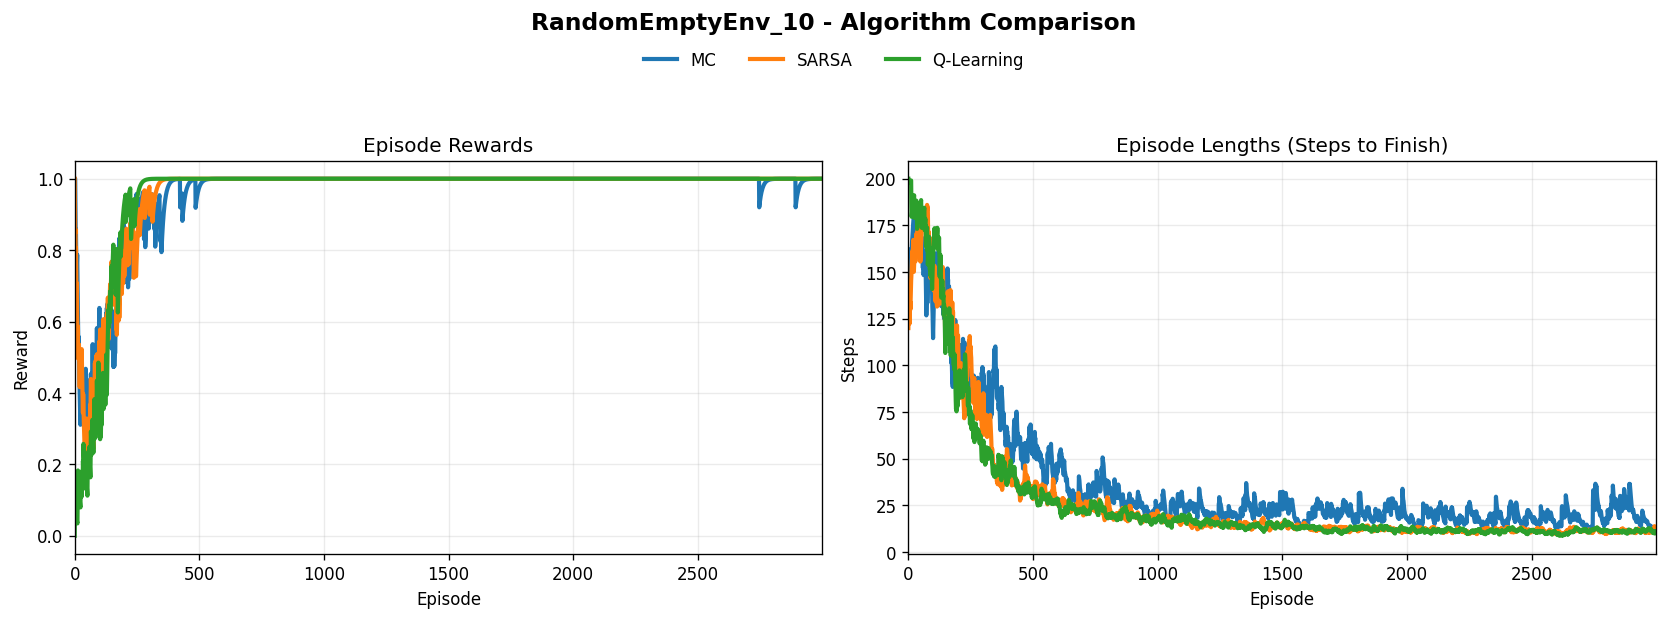

(<Figure size 1680x624 with 2 Axes>,
 array([<Axes: title={'center': 'Episode Rewards'}, xlabel='Episode', ylabel='Reward'>,
        <Axes: title={'center': 'Episode Lengths (Steps to Finish)'}, xlabel='Episode', ylabel='Steps'>],
       dtype=object))

In [ ]:
# Plot comparison for RandomEmptyEnv_10
results_empty = {
    'MC': {'rewards': rewards_mc_empty, 'lengths': lengths_mc_empty, 'eval': eval_mc},
    'SARSA': {'rewards': rewards_sarsa_empty, 'lengths': lengths_sarsa_empty, 'eval': eval_sarsa},
    'Q-Learning': {'rewards': rewards_qlearn_empty, 'lengths': lengths_qlearn_empty, 'eval': eval_qlearn}
}

plot_training_results(results_empty, "RandomEmptyEnv_10 - Algorithm Comparison")


### Video: Trained Agent Demonstration

The following GIF shows the trained Sarsa agent navigating to the goal.


Recording Trained Sarsa Agent - RandomEmptyEnv_10...
Saved trained_agent_empty.gif (12 frames, 11 steps)


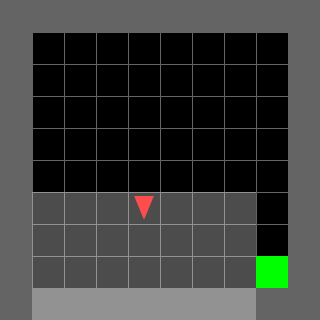

In [ ]:
env_empty_record = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array'))
record_and_display(env_empty_record, Q_sarsa_empty, EMPTY_CONFIG['avoid_actions'],
                   "Trained Sarsa Agent - RandomEmptyEnv_10", "trained_agent_empty.gif")

## RandomKeyMEnv_10

### Training


In [ ]:
# Hyperparameters for Key Environment
KEY_CONFIG = {
    'max_steps': 1000,
    'n_episodes': 10000,
    'gamma': 0.99,
    'alpha': 0.1,
    'epsilon': 1.0,
    'epsilon_min': 0.1,
    'epsilon_decay': 0.999,
    'decay_every' : 5,
    'avoid_actions': [4,6],
    'print_window': 300
}

print("Training Configuration for RandomKeyMEnv_10:")
for k, v in KEY_CONFIG.items():
    print(f"  {k}: {v}")


Training Configuration for RandomKeyMEnv_10:
  max_steps: 1000
  n_episodes: 10000
  gamma: 0.99
  alpha: 0.1
  epsilon: 1.0
  epsilon_min: 0.1
  epsilon_decay: 0.999
  decay_every: 5
  avoid_actions: [4, 6]
  print_window: 300


In [ ]:
# Train Monte Carlo on RandomKeyMEnv_10
print_with_seperator("Training Monte Carlo on RandomKeyMEnv_10")


env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=KEY_CONFIG['max_steps']))
Q_mc_key, rewards_mc_key, lengths_mc_key = monte_carlo(
    env_key,
    n_episodes=KEY_CONFIG['n_episodes'],
    gamma=KEY_CONFIG['gamma'],
    epsilon=KEY_CONFIG['epsilon'],
    epsilon_min=KEY_CONFIG['epsilon_min'],
    epsilon_decay=KEY_CONFIG['epsilon_decay'],
    decay_every=KEY_CONFIG['decay_every'],
    print_window=KEY_CONFIG['print_window'],
    avoid_actions=KEY_CONFIG['avoid_actions']
)


Training Monte Carlo on RandomKeyMEnv_10
Episode 300/10000, Avg Reward: -8.207, Avg Length: 930.7, Dones: 65, Epsilon: 0.9417
Episode 600/10000, Avg Reward: -6.864, Avg Length: 827.0, Dones: 132, Epsilon: 0.8869
Episode 900/10000, Avg Reward: -5.416, Avg Length: 704.8, Dones: 196, Epsilon: 0.8352
Episode 1200/10000, Avg Reward: -3.391, Avg Length: 523.6, Dones: 257, Epsilon: 0.7865
Episode 1500/10000, Avg Reward: -2.348, Avg Length: 425.9, Dones: 275, Epsilon: 0.7407
Episode 1800/10000, Avg Reward: -1.424, Avg Length: 338.9, Dones: 291, Epsilon: 0.6976
Episode 2100/10000, Avg Reward: -0.901, Avg Length: 286.4, Dones: 292, Epsilon: 0.6569
Episode 2400/10000, Avg Reward: -0.307, Avg Length: 229.7, Dones: 297, Epsilon: 0.6186
Episode 2700/10000, Avg Reward: -0.125, Avg Length: 211.5, Dones: 297, Epsilon: 0.5826
Episode 3000/10000, Avg Reward: 0.053, Avg Length: 193.8, Dones: 298, Epsilon: 0.5486
Episode 3300/10000, Avg Reward: 0.329, Avg Length: 167.1, Dones: 300, Epsilon: 0.5167
Episode 

In [ ]:
# Train SARSA on RandomKeyMEnv_10
print_with_seperator("Training SARSA on RandomKeyMEnv_10")

env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=KEY_CONFIG['max_steps']))
Q_sarsa_key, rewards_sarsa_key, lengths_sarsa_key = sarsa(
    env_key,
    n_episodes=KEY_CONFIG['n_episodes'],
    alpha=KEY_CONFIG['alpha'],
    gamma=KEY_CONFIG['gamma'],
    epsilon=KEY_CONFIG['epsilon'],
    epsilon_min=KEY_CONFIG['epsilon_min'],
    epsilon_decay=KEY_CONFIG['epsilon_decay'],
    decay_every=KEY_CONFIG['decay_every'],
    print_window=KEY_CONFIG['print_window'],
    avoid_actions=KEY_CONFIG['avoid_actions']
)


Training SARSA on RandomKeyMEnv_10
Episode 300/10000, Avg Reward: -8.298, Avg Length: 938.9, Dones: 56, Epsilon: 0.9417
Episode 600/10000, Avg Reward: -7.867, Avg Length: 911.2, Dones: 82, Epsilon: 0.8869
Episode 900/10000, Avg Reward: -6.934, Avg Length: 832.8, Dones: 122, Epsilon: 0.8352
Episode 1200/10000, Avg Reward: -5.569, Avg Length: 714.9, Dones: 174, Epsilon: 0.7865
Episode 1500/10000, Avg Reward: -4.345, Avg Length: 607.5, Dones: 219, Epsilon: 0.7407
Episode 1800/10000, Avg Reward: -3.833, Avg Length: 559.3, Dones: 228, Epsilon: 0.6976
Episode 2100/10000, Avg Reward: -3.068, Avg Length: 489.1, Dones: 247, Epsilon: 0.6569
Episode 2400/10000, Avg Reward: -2.136, Avg Length: 398.6, Dones: 255, Epsilon: 0.6186
Episode 2700/10000, Avg Reward: -1.402, Avg Length: 330.8, Dones: 272, Epsilon: 0.5826
Episode 3000/10000, Avg Reward: -0.712, Avg Length: 265.9, Dones: 284, Epsilon: 0.5486
Episode 3300/10000, Avg Reward: -0.245, Avg Length: 222.8, Dones: 295, Epsilon: 0.5167
Episode 3600/

In [ ]:
# Train Q-Learning on RandomKeyMEnv_10
print_with_seperator("Training Q-Learning on RandomKeyMEnv_10")

env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=KEY_CONFIG['max_steps']))
Q_qlearn_key, rewards_qlearn_key, lengths_qlearn_key = q_learning(
    env_key,
    n_episodes=KEY_CONFIG['n_episodes'],
    alpha=KEY_CONFIG['alpha'],
    gamma=KEY_CONFIG['gamma'],
    epsilon=KEY_CONFIG['epsilon'],
    epsilon_min=KEY_CONFIG['epsilon_min'],
    epsilon_decay=KEY_CONFIG['epsilon_decay'],
    decay_every=KEY_CONFIG['decay_every'],
    print_window=KEY_CONFIG['print_window'],
    avoid_actions=KEY_CONFIG['avoid_actions']
  )


Training Q-Learning on RandomKeyMEnv_10
Episode 300/10000, Avg Reward: -8.094, Avg Length: 923.0, Dones: 72, Epsilon: 0.9417
Episode 600/10000, Avg Reward: -7.584, Avg Length: 888.9, Dones: 96, Epsilon: 0.8869
Episode 900/10000, Avg Reward: -6.416, Avg Length: 785.8, Dones: 133, Epsilon: 0.8352
Episode 1200/10000, Avg Reward: -5.729, Avg Length: 725.6, Dones: 158, Epsilon: 0.7865
Episode 1500/10000, Avg Reward: -4.892, Avg Length: 646.5, Dones: 173, Epsilon: 0.7407
Episode 1800/10000, Avg Reward: -4.823, Avg Length: 641.6, Dones: 178, Epsilon: 0.6976
Episode 2100/10000, Avg Reward: -4.541, Avg Length: 617.4, Dones: 191, Epsilon: 0.6569
Episode 2400/10000, Avg Reward: -3.513, Avg Length: 521.7, Dones: 211, Epsilon: 0.6186
Episode 2700/10000, Avg Reward: -3.200, Avg Length: 490.0, Dones: 210, Epsilon: 0.5826
Episode 3000/10000, Avg Reward: -2.478, Avg Length: 426.2, Dones: 235, Epsilon: 0.5486
Episode 3300/10000, Avg Reward: -1.776, Avg Length: 360.3, Dones: 248, Epsilon: 0.5167
Episode 

### Evaluation and Comparison


In [ ]:
print_with_seperator("Evaluating Trained Policies (100 episodes each)")

env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=300))

eval_mc_key = evaluate_policy(env_key, Q_mc_key, max_steps=300, avoid_actions=KEY_CONFIG['avoid_actions'])
eval_sarsa_key = evaluate_policy(env_key, Q_sarsa_key, max_steps=300, avoid_actions=KEY_CONFIG['avoid_actions'])
eval_qlearn_key = evaluate_policy(env_key, Q_qlearn_key, max_steps=300, avoid_actions=KEY_CONFIG['avoid_actions'])

print(f"\nMonte Carlo:")
print(f"  Avg Reward: {eval_mc_key['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_mc_key['avg_steps']:.1f}")
print(f"  Success Rate: {eval_mc_key['success_rate']*100:.1f}%")

print(f"\nSARSA:")
print(f"  Avg Reward: {eval_sarsa_key['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_sarsa_key['avg_steps']:.1f}")
print(f"  Success Rate: {eval_sarsa_key['success_rate']*100:.1f}%")

print(f"\nQ-Learning:")
print(f"  Avg Reward: {eval_qlearn_key['avg_reward']:.3f}")
print(f"  Avg Steps: {eval_qlearn_key['avg_steps']:.1f}")
print(f"  Success Rate: {eval_qlearn_key['success_rate']*100:.1f}%")


Evaluating Trained Policies (100 episodes each)

Monte Carlo:
  Avg Reward: -2.342
  Avg Steps: 266.7
  Success Rate: 12.0%

SARSA:
  Avg Reward: 0.449
  Avg Steps: 99.1
  Success Rate: 72.0%

Q-Learning:
  Avg Reward: 1.496
  Avg Steps: 38.4
  Success Rate: 94.0%


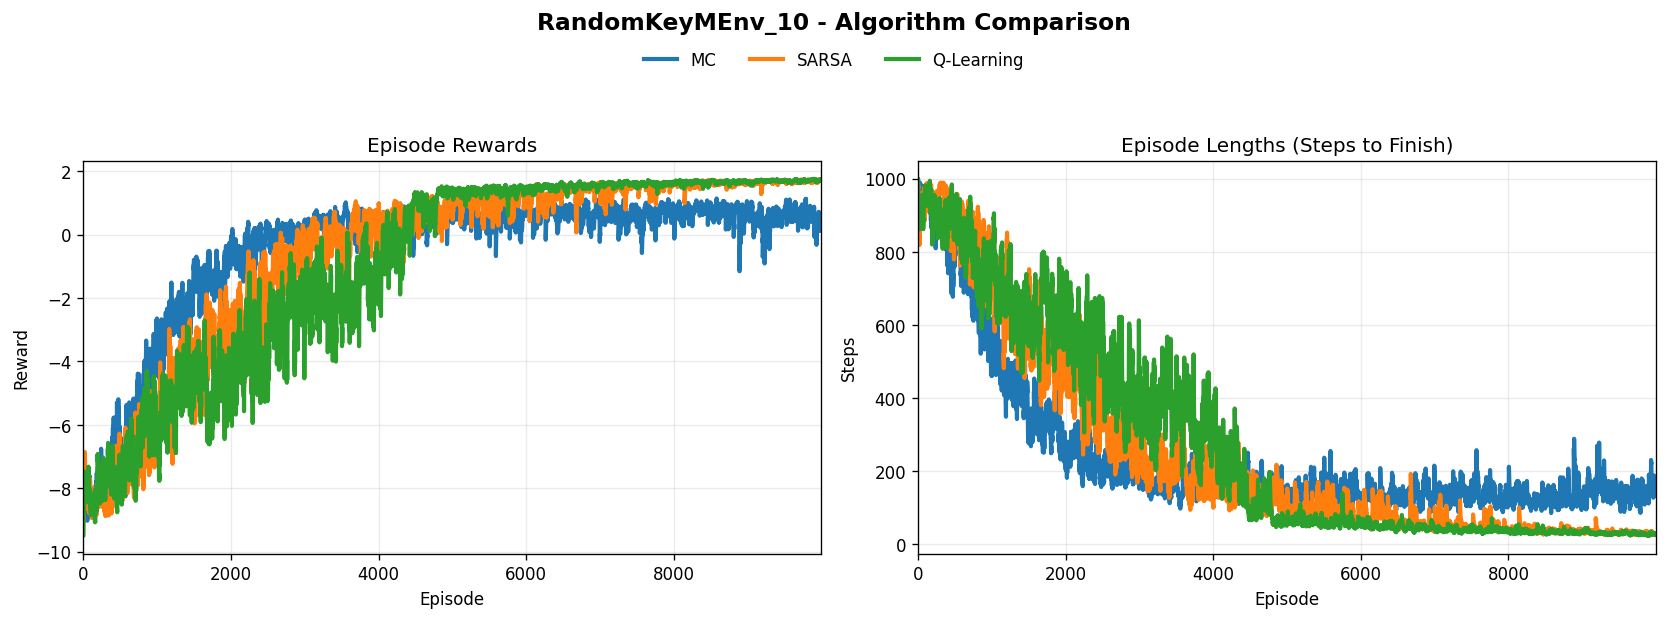

(<Figure size 1680x624 with 2 Axes>,
 array([<Axes: title={'center': 'Episode Rewards'}, xlabel='Episode', ylabel='Reward'>,
        <Axes: title={'center': 'Episode Lengths (Steps to Finish)'}, xlabel='Episode', ylabel='Steps'>],
       dtype=object))

In [ ]:
# Plot comparison for RandomKeyMEnv_10
results_key = {
    'MC': {'rewards': rewards_mc_key, 'lengths': lengths_mc_key, 'eval': eval_mc_key},
    'SARSA': {'rewards': rewards_sarsa_key, 'lengths': lengths_sarsa_key, 'eval': eval_sarsa_key},
    'Q-Learning': {'rewards': rewards_qlearn_key, 'lengths': lengths_qlearn_key, 'eval': eval_qlearn_key}
}

plot_training_results(results_key, "RandomKeyMEnv_10 - Algorithm Comparison")


### Video: Trained Agent Demonstration

The following GIF shows the trained Sarsa and Q-Learning agent navigating to the goal.

Recording Trained Monte Carlo Agent - RandomKeyMEnv_10...
Saved trained_agent_key.gif (22 frames, 21 steps)


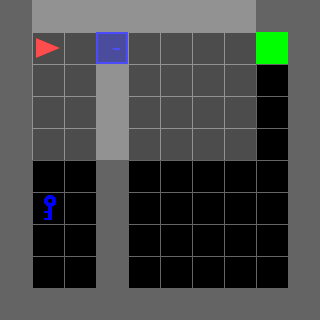

In [ ]:
# =============================================================================
# VIDEO: Trained Agent on RandomKeyMEnv_10
# =============================================================================

env_key_record = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=300))
record_and_display(env_key_record, Q_sarsa_key, KEY_CONFIG['avoid_actions'],
                   "Trained Sarsa Agent - RandomKeyMEnv_10", "trained_agent_key.gif")


Recording Trained Q Learning Agent - RandomKeyMEnv_10...
Saved trained_agent_key.gif (27 frames, 26 steps)


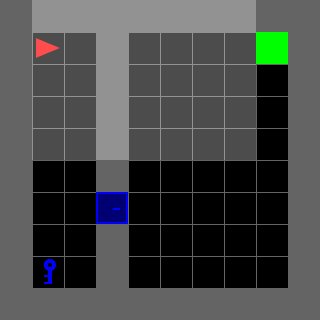

In [ ]:
env_key_record = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=300))
record_and_display(env_key_record, Q_qlearn_key, KEY_CONFIG['avoid_actions'],
                   "Trained Q Learning Agent - RandomKeyMEnv_10", "trained_agent_key.gif")
